# Spaceship Titanic Kaggle Competition
My attempt at this Kaggle Competition [link](https://www.kaggle.com/competitions/spaceship-titanic/data)

In [284]:
%pip install kaggle pandas numpy matplotlib scikit-learn > /dev/null

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Downloading Dataset

In [285]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import zipfile

# Create the data folder if it doesn't exist
os.makedirs('data', exist_ok=True)

# Authenticate and download the dataset files
api = KaggleApi()
api.authenticate()
api.competition_download_files('spaceship-titanic', path='data')

try: 
    with zipfile.ZipFile('data/spaceship-titanic.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
except Exception as e:
    print('Could not unzip file', e)

In [286]:
data_raw_all = pd.read_csv('data/train.csv')
data_raw_val = pd.read_csv('data/test.csv')

In [287]:
data_raw_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Exploring Data

## Cabins

From the below it seems that each person is in a cabin 6561 cabins for 8693 people. Maybe it would be good to associate with each person `cabin_mates` which is equal to how many people are in their cabin with them.

In [288]:
len(data_raw_all['Cabin'].unique()), len(data_raw_all['Cabin'])

(6561, 8693)

In [289]:
data_raw_all[['Cabin', 'PassengerId']]

,Cabin,PassengerId
0,B/0/P,0001_01
1,F/0/S,0002_01
2,A/0/S,0003_01
3,A/0/S,0003_02
4,F/1/S,0004_01
...,...,...
8688,A/98/P,9276_01
8689,G/1499/S,9278_01
8690,G/1500/S,9279_01
8691,E/608/S,9280_01


In [290]:
joined_cabin_counts = pd.concat([data_raw_all, data_raw_val])[['Cabin', 'PassengerId']].groupby('Cabin').count()
joined_cabin_counts = joined_cabin_counts.rename(columns={'PassengerId': 'cabin_mates'})
joined_cabin_counts


data_raw_all_psg_cnt = data_raw_all.merge(cabin_counts, left_on='Cabin', right_on='Cabin', how='left')
data_raw_val_psg_cnt = data_raw_val.merge(cabin_counts_val, left_on='Cabin', right_on='Cabin', how='left')
print(f"{(len(data_raw_val), len(data_raw_val_psg_cnt))=}")

(len(data_raw_val), len(data_raw_val_psg_cnt))=(4277, 4277)


In [291]:
data_raw_all_psg_cnt.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'cabin_mates'],
      dtype='object')

Text(0, 0.5, 'Frequency')

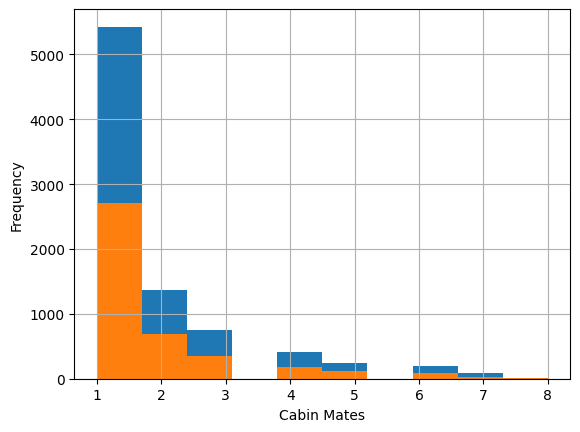

In [292]:
data_raw_all_psg_cnt['cabin_mates'].hist()
plt.xlabel("Cabin Mates")
plt.ylabel("Frequency")

data_raw_val_psg_cnt['cabin_mates'].hist()
plt.xlabel("Cabin Mates")
plt.ylabel("Frequency")

## Closer look at Cabin Numbers

It looks like cabin numbers have some underlying structure (for example: `G/1499/S` `B\0\P`). Let's try breaking them into columns and see if it is correlated

In [293]:
data_raw_all_psg_cnt[['c0', 'c1', 'c2']] = data_raw_all_psg_cnt['Cabin'].str.split('/', expand=True)
data_raw_all_psg_cnt['c1'] = data_raw_all_psg_cnt['c1'].astype(np.float64)

data_raw_val_psg_cnt[['c0', 'c1', 'c2']] = data_raw_val_psg_cnt['Cabin'].str.split('/', expand=True)
data_raw_val_psg_cnt['c1'] = data_raw_val_psg_cnt['c1'].astype(np.float64)

In [294]:
data_raw_all_psg_cnt['c0'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

<Axes: >

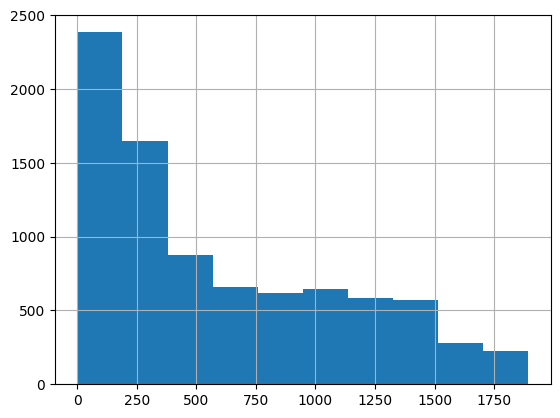

In [295]:
data_raw_all_psg_cnt['c1'].hist()

In [296]:
data_raw_all_psg_cnt['c2'].unique()

array(['P', 'S', nan], dtype=object)

## Names

In [297]:
data_raw_all_psg_cnt['Transported'].astype(np.int64)

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 8693, dtype: int64

In [298]:
from sklearn.preprocessing import OrdinalEncoder

data_raw_all_psg_cnt[['first_name', 'last_name']] = data_raw_all_psg_cnt['Name'].str.split(' ', expand=True)
data_raw_val_psg_cnt[['first_name', 'last_name']] = data_raw_val_psg_cnt['Name'].str.split(' ', expand=True)
# data_raw_all_psg_cnt['last_name'] = data_raw_all_psg_cnt['last_name'].to_numeric(row, errors='coerce')
# names.rename(columns={0: 'first_name', 1: 'last_name'}, inplace=True)

# data_raw_all_psg_cnt[['first_name', 'last_name', 'Transported']]

enc = OrdinalEncoder()
# enc_x = enc.fit_transform(data_raw_all_psg_cnt['last_name'].values.reshape(-1, 1))
def ln_length(row):
    if pd.isna(row['last_name']):
        return 0
    return len(row['last_name'])
def fn_length(row):
    if pd.isna(row['first_name']):
        return 0
    return len(row['first_name'])

data_raw_all_psg_cnt['ln_length'] = data_raw_all_psg_cnt.apply(ln_length, axis=1)
data_raw_all_psg_cnt['fn_length'] = data_raw_all_psg_cnt.apply(fn_length, axis=1)
data_raw_all_psg_cnt['y_enc'] = data_raw_all_psg_cnt['Transported'].astype(np.int64)

data_raw_val_psg_cnt['ln_length'] = data_raw_val_psg_cnt.apply(ln_length, axis=1)
data_raw_val_psg_cnt['fn_length'] = data_raw_val_psg_cnt.apply(fn_length, axis=1)

data_raw_all_psg_cnt[['ln_length', 'fn_length', 'y_enc']]

,ln_length,fn_length,y_enc
0,9,5,0
1,5,6,1
2,6,6,0
3,6,5,0
4,11,5,1
...,...,...,...
8688,9,7,0
8689,9,5,0
8690,6,5,1
8691,9,6,0


In [305]:
data_raw_all_psg_cnt['last_name'].unique()

array(['Ofracculy', 'Vines', 'Susent', ..., 'Fort', 'Workmanson',
       'Sionerorly'], shape=(2218,), dtype=object)

In [300]:
data_raw_all_psg_cnt[['ln_length', 'fn_length', 'y_enc']].corr()['y_enc']

ln_length   -0.018799
fn_length    0.044753
y_enc        1.000000
Name: y_enc, dtype: float64

### From the above name length does have some correlation with survival!

## Grouping by last name

In [311]:
joined_fam_counts = pd.concat([data_raw_all_psg_cnt, data_raw_val_psg_cnt])[['last_name', 'PassengerId']].groupby('last_name').count()
joined_fam_counts = joined_fam_counts.rename(columns={'PassengerId': 'family_members'})
joined_fam_counts


data_raw_all_psg_cnt_2 = data_raw_all_psg_cnt.merge(joined_fam_counts, left_on='last_name', right_on='last_name', how='left')
data_raw_val_psg_cnt_2 = data_raw_val_psg_cnt.merge(joined_fam_counts, left_on='last_name', right_on='last_name', how='left')
# print(f"{(len(data_raw_val), len(data_raw_val_psg_cnt))=}")
data_raw_all_psg_cnt_2

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,cabin_mates,c0,c1,c2,first_name,last_name,ln_length,fn_length,y_enc,family_members
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,1.0,B,0.0,P,Maham,Ofracculy,9,5,0,3.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,1.0,F,0.0,S,Juanna,Vines,5,6,1,4.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,2.0,A,0.0,S,Altark,Susent,6,6,0,7.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,2.0,A,0.0,S,Solam,Susent,6,5,0,7.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,1.0,F,1.0,S,Willy,Santantines,11,5,1,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,1.0,A,98.0,P,Gravior,Noxnuther,9,7,0,3.0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,1.0,G,1499.0,S,Kurta,Mondalley,9,5,0,5.0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,1.0,G,1500.0,S,Fayey,Connon,6,5,1,8.0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,2.0,E,608.0,S,Celeon,Hontichre,9,6,0,7.0


In [313]:
data_raw_all_psg_cnt_2.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'cabin_mates', 'c0', 'c1', 'c2', 'first_name',
       'last_name', 'ln_length', 'fn_length', 'y_enc', 'family_members'],
      dtype='object')

In [315]:
data_raw_all_psg_cnt_2['y_enc'] = data_raw_all_psg_cnt_2['Transported'].astype(np.int64)
data_raw_all_psg_cnt_2[['family_members', 'y_enc']].corr()['y_enc']

family_members   -0.055747
y_enc             1.000000
Name: y_enc, dtype: float64

([<matplotlib.axis.XTick at 0x7177b0ee5bd0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19')])

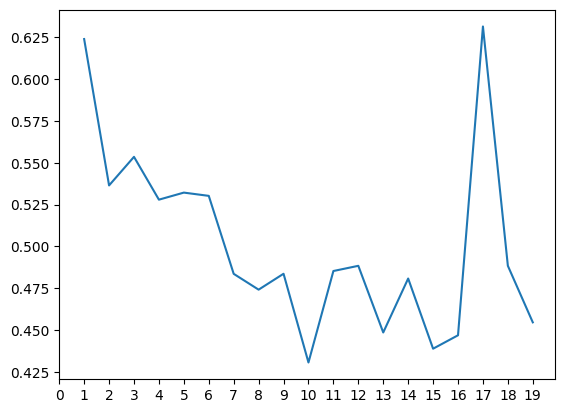

In [326]:
survivablity_by_family_count = data_raw_all_psg_cnt_2[['family_members', 'y_enc']].groupby('family_members').mean()
plt.plot(survivablity_by_family_count.index, survivablity_by_family_count['y_enc'])
plt.xticks(np.arange(0,20))

## People in Cabin?

In [358]:
families_in_cabin = pd.concat([data_raw_all_psg_cnt, data_raw_val_psg_cnt])[['Cabin', 'last_name']].groupby('Cabin').nunique()
families_in_cabin = families_in_cabin.rename(columns={'last_name': 'fams_in_cabin'})
families_in_cabin


data_raw_all_psg_cnt_3 = data_raw_all_psg_cnt_2.merge(families_in_cabin, left_on='Cabin', right_on='Cabin', how='left')
data_raw_val_psg_cnt_3 = data_raw_val_psg_cnt_2.merge(families_in_cabin, left_on='Cabin', right_on='Cabin', how='left')
# # print(f"{(len(data_raw_val), len(data_raw_val_psg_cnt))=}")
data_raw_all_psg_cnt_3

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,c0,c1,c2,first_name,last_name,ln_length,fn_length,y_enc,family_members,fams_in_cabin
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,B,0.0,P,Maham,Ofracculy,9,5,0,3.0,1.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,F,0.0,S,Juanna,Vines,5,6,1,4.0,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,A,0.0,S,Altark,Susent,6,6,0,7.0,1.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,A,0.0,S,Solam,Susent,6,5,0,7.0,1.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,F,1.0,S,Willy,Santantines,11,5,1,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,...,A,98.0,P,Gravior,Noxnuther,9,7,0,3.0,1.0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,G,1499.0,S,Kurta,Mondalley,9,5,0,5.0,1.0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,...,G,1500.0,S,Fayey,Connon,6,5,1,8.0,1.0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,...,E,608.0,S,Celeon,Hontichre,9,6,0,7.0,1.0


# Preprocessing

In [359]:
num_cols = ['Age', 'c1', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'cabin_mates', 'ln_length', 'fn_length', 'family_members', 'fams_in_cabin']
str_cols = ['HomePlanet', 'c0', 'c2', 'Destination', 'CryoSleep', 'VIP']

removed_cols = ['Cabin', 'Name']

In [360]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin

# Custom Transformer to Convert Booleans to Strings
class BooleanToStringTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Convert booleans to strings
        return np.where(X.astype(str) == "True", "True", 
                        np.where(X.astype(str) == "False", "False", X))


# Pipeline for categorical columns: Ordinal Encoding with NaN as a new category
cat_pipeline = Pipeline([
    ('bool_to_str', BooleanToStringTransformer()),  # Convert booleans to strings
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),  # Replace NaNs with "Missing"
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encode categories
])

# Pipeline for numerical columns: Median imputation and scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Fill missing values with median
    ('scaler', StandardScaler())  # Normalize numerical data
])

# Column Transformer: Applies different transformations to different column types
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, str_cols)
])

y_all = data_raw_all_psg_cnt['Transported'].astype(np.int64)
X_all = preprocessor.fit_transform(data_raw_all_psg_cnt_3)
X_val = preprocessor.transform(data_raw_val_psg_cnt_3)

X_all

array([[ 0.71194537, -1.17723796, -0.33310466, ...,  3.        ,
         0.        ,  0.        ],
       [-0.33403748, -1.17723796, -0.16807343, ...,  3.        ,
         0.        ,  0.        ],
       [ 2.03685698, -1.17723796, -0.2680006 , ...,  3.        ,
         0.        ,  2.        ],
       ...,
       [-0.1945731 ,  1.78362735, -0.33310466, ...,  3.        ,
         0.        ,  0.        ],
       [ 0.22382004,  0.02289945, -0.33310466, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.06060632,  0.02289945, -0.14233462, ...,  3.        ,
         0.        ,  0.        ]], shape=(8693, 18))

In [395]:
from sklearn.model_selection import train_test_split

# Perform train-test split (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_all, None, y_all, None

# len(X_train), len(X_test)

# Classify

In [362]:
from sklearn.linear_model import LogisticRegression
lin_reg = LogisticRegression().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7916307161345988 test_score=0.7711328349626222


In [363]:
from sklearn.linear_model import RidgeClassifier
lin_reg = RidgeClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.76775956284153 test_score=0.7481311098332375


In [364]:
from sklearn.linear_model import SGDClassifier
lin_reg = SGDClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7178602243313201 test_score=0.7245543415756182


In [365]:
from sklearn.ensemble import AdaBoostClassifier
lin_reg = AdaBoostClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7878918607995399 test_score=0.7602070155261644


In [366]:
from sklearn.ensemble import BaggingClassifier
lin_reg = BaggingClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.9873454127121082 test_score=0.7717078780908568


In [367]:
from sklearn.ensemble import GradientBoostingClassifier
lin_reg = GradientBoostingClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.8267184354328444 test_score=0.7924094307073031


In [368]:
from sklearn.ensemble import HistGradientBoostingClassifier
lin_reg = HistGradientBoostingClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.8960310612597067 test_score=0.8067855089131685


In [369]:
from sklearn.ensemble import RandomForestClassifier
lin_reg = RandomForestClassifier().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=1.0 test_score=0.7998849913743531


In [370]:
from sklearn.naive_bayes import GaussianNB
lin_reg = GaussianNB().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7188668392292206 test_score=0.721679125934445


In [371]:
from sklearn.naive_bayes import BernoulliNB
lin_reg = BernoulliNB().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7522289329882083 test_score=0.7400805060379528


In [372]:
from sklearn.svm import LinearSVC
lin_reg = LinearSVC().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.7943629565717573 test_score=0.7734330074755607


In [373]:
from sklearn.svm import NuSVC
lin_reg = NuSVC().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.8051481161921197 test_score=0.7757331799884991


In [374]:
from sklearn.svm import SVR
lin_reg = SVR().fit(X_train, y_train)
train_score = lin_reg.score(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)

print(f"{train_score=} {test_score=}")

train_score=0.434421882713772 test_score=0.35549056922613864


## BEST Classifier: RandomForestClassifier

Fine tuning time

In [385]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

distributions = dict(n_estimators=np.arange(5, 500, 25),
                     max_depth=np.arange(5, 500, 25),
                     min_samples_split=np.arange(2, 50, 3))
clf = RandomizedSearchCV(RandomForestClassifier(),
                         distributions, random_state=42, n_iter=500, verbose=10, n_jobs=-1,
                         cv=5)
search = clf.fit(X_train, y_train)
search.best_params_

#{'n_estimators': np.int64(255),
# 'min_samples_split': np.int64(32),
# 'max_depth': np.int64(205)}


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 2/5; 3/500] START max_depth=330, min_samples_split=2, n_estimators=55.......
[CV 2/5; 3/500] END max_depth=330, min_samples_split=2, n_estimators=55;, score=0.763 total time=   0.5s
[CV 3/5; 4/500] START max_depth=430, min_samples_split=11, n_estimators=55......
[CV 3/5; 4/500] END max_depth=430, min_samples_split=11, n_estimators=55;, score=0.803 total time=   0.5s
[CV 4/5; 5/500] START max_depth=5, min_samples_split=20, n_estimators=305.......
[CV 4/5; 5/500] END max_depth=5, min_samples_split=20, n_estimators=305;, score=0.784 total time=   1.1s
[CV 4/5; 6/500] START max_depth=230, min_samples_split=17, n_estimators=280.....
[CV 4/5; 6/500] END max_depth=230, min_samples_split=17, n_estimators=280;, score=0.823 total time=   2.1s
[CV 1/5; 10/500] START max_depth=355, min_samples_split=17, n_estimators=155....
[CV 1/5; 10/500] END max_depth=355, min_samples_split=17, n_estimators=155;, score=0.751 total time=   1.3s


{'n_estimators': np.int64(255),
 'min_samples_split': np.int64(32),
 'max_depth': np.int64(205)}

In [393]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

distributions = dict(max_leaf_nodes=np.arange(31, 500, 10),
                     max_depth=np.arange(1, 100, 2),
                     min_samples_leaf=np.arange(20, 200, 10),
                     l2_regularization=[0,0.2,0.3,0.4,0.5,0.6]
                    )
clf = RandomizedSearchCV(HistGradientBoostingClassifier(),
                         distributions, 
                         random_state=42, 
                         n_iter=1000, 
                         n_jobs=-1,
                         cv=5)
search = clf.fit(X_train, y_train)
search.best_params_
"""
{'min_samples_leaf': np.int64(160),
 'max_leaf_nodes': np.int64(211),
 'max_depth': np.int64(5),
 'l2_regularization': 0.5}
"""

{'min_samples_leaf': np.int64(160),
 'max_leaf_nodes': np.int64(211),
 'max_depth': np.int64(5),
 'l2_regularization': 0.5}

In [396]:
final_clf = HistGradientBoostingClassifier(
    min_samples_leaf=160, 
    max_leaf_nodes=211,
    max_depth=5,
    l2_regularization=0.5
)
final_clf.fit(X_train, y_train)
train_score = final_clf.score(X_train, y_train)
# test_score = final_clf.score(X_test, y_test)

# print(f"{train_score=} {test_score=}")
train_score

0.8311284941907282

# Final Submission

In [232]:
y_pred

array([1, 0, 1, ..., 1, 1, 0], shape=(4177,))

In [233]:
data_raw_val

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [397]:
y_pred = final_clf.predict(X_val)

res = pd.DataFrame({
    "PassengerId": data_raw_val['PassengerId'],
    "Transported": y_pred.astype(np.bool)
})

In [398]:
res

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [399]:
res.to_csv('submission_3.csv', index=False)

In [138]:
data_raw_all_psg_cnt['Transported']

0       False
1        True
2       False
3       False
4        True
        ...  
8489    False
8490    False
8491     True
8492    False
8493     True
Name: Transported, Length: 8494, dtype: bool